## 切り抜き加工の説明用

In [1]:
import bz2
import os
import os.path as osp
import sys

import cv2
import dlib
import numpy as np
import requests
import scipy.ndimage
from PIL import Image
from tqdm import tqdm

LANDMARKS_MODEL_URL = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"

DiffAEの作者が用意した関数を利用

In [2]:
class LandmarksDetector:
    def __init__(self, predictor_model_path):
        """
        :param predictor_model_path: path to shape_predictor_68_face_landmarks.dat file
        """
        self.detector = (
            dlib.get_frontal_face_detector()
        )  # cnn_face_detection_model_v1 also can be used
        self.shape_predictor = dlib.shape_predictor(predictor_model_path)

    def get_landmarks(self, image):
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dets = self.detector(img, 1)

        for detection in dets:
            face_landmarks = [
                (item.x, item.y)
                for item in self.shape_predictor(img, detection).parts()
            ]
            return face_landmarks


def unpack_bz2(src_path):
    dst_path = src_path[:-4]
    if os.path.exists(dst_path):
        print("cached")
        return dst_path
    data = bz2.BZ2File(src_path).read()
    with open(dst_path, "wb") as fp:
        fp.write(data)
    return dst_path


def work_landmark(raw_img_path, img_name, face_landmarks):
    face_img_name = "%s.jpg" % (os.path.splitext(img_name)[0],)
    aligned_face_path = os.path.join(ALIGNED_IMAGES_DIR, face_img_name)
    if os.path.exists(aligned_face_path):
        return
    image_align(raw_img_path, aligned_face_path, face_landmarks, output_size=256)


def get_file(src, tgt):
    if os.path.exists(tgt):
        print("cached")
        return tgt
    tgt_dir = os.path.dirname(tgt)
    if not os.path.exists(tgt_dir):
        os.makedirs(tgt_dir)
    file = requests.get(src)
    open(tgt, "wb").write(file.content)
    return tgt

In [3]:
landmarks_model_path = unpack_bz2(
    get_file(
        "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2",
        "temp/shape_predictor_68_face_landmarks.dat.bz2",
    )
)

cached
cached


画像の指定

In [4]:
img_dir = "imgs_align/"  # 語尾に「/」つける
dir_list = sorted(os.listdir(img_dir))
for i, file in enumerate(dir_list):
    print(f"{i}: {file}")

0: azuki_default.png
1: ceo_default.png
2: check1.png
3: check2.png
4: danda_default.png
5: detective.png
6: detective_02.png
7: mio_happy.png
8: mio_shock.png
9: mio_silence.png
10: mio_u.png
11: nanko_default.png
12: ookawa_angry.png
13: ookawa_angry2.png
14: ookawa_default.png
15: ookawa_high.png
16: ookawa_regret.png
17: ookawa_smile.png
18: ookawa_surprised.png
19: pharmacist.png
20: saki.png
21: saki_glasses.png
22: sandy.png
23: takebe_default.png
24: test01.png
25: test01_02.png
26: test01_03.png
27: test01_04.png
28: woman_default.png
29: yotaka_angry.png
30: yotaka_angry2.png
31: yotaka_bald.png
32: yotaka_bushy.png
33: yotaka_default.png
34: yotaka_gj.png
35: yotaka_smile.png
36: yotaka_smile2.png


In [5]:
# [from,to]の順で２画像選択
indices = [33, 35]

IMAGES = []
IMAGES_NAME = []
LANDMARKS = []
for i in indices:
    img_path = img_dir + dir_list[i]
    
    # 読み込んだ画像の名前を格納
    img_name = os.path.splitext(dir_list[i])[0]
    IMAGES_NAME.append(img_name)

    # cv2で読み込み
    img = cv2.imread(img_path)
    # bgrからrgbに変換
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    IMAGES.append(img)
    # モデルの読み込み
    landmarks_detector = LandmarksDetector(landmarks_model_path)
    
    # ランドマークの取得
    # 画像のパスを入力したら自動でランドマークを検出してくれる
    landmark = landmarks_detector.get_landmarks(img_path)
    LANDMARKS.append(landmark)

ランドマークの確認

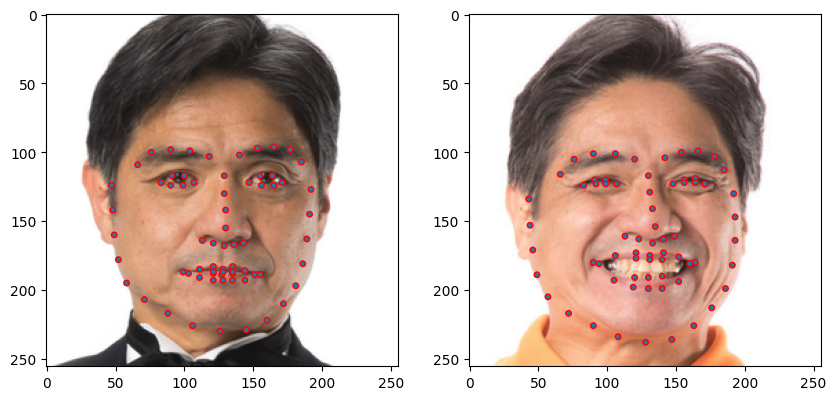

In [6]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, land in enumerate(LANDMARKS):
    ax[i].imshow(IMAGES[i])
    for la in land:
        r = patches.Circle(xy=la, radius=2, ec="r")
        ax[i].add_patch(r)

plt.show()
# plt.savefig('test/landmark.png')

ランドマークを部位ごとに分ける

In [7]:
lm = np.array(LANDMARKS)
lm_eyebrow_left = lm[:, 17:22]  # left-right
lm_eyebrow_right = lm[:, 22:27]  # left-right
lm_nose = lm[:, 27:31]  # top-down
lm_nostrils = lm[:, 31:36]  # top-down
lm_eye_left = lm[:, 36:42]  # left-clockwise
lm_eye_right = lm[:, 42:48]  # left-clockwise
lm_mouth_outer = lm[:, 48:60]  # left-clockwise
lm_mouth_inner = lm[:, 60:68]  # left-clockwise

顔を切り抜くためのランドマークを格納

In [12]:
# コピーを作成
img_from = IMAGES[0].copy()
img_to = IMAGES[1].copy()

# 点を直線で結んだときに多角形となる順番に格納する
pt_from = np.concatenate([lm[0, :17], np.flipud(lm[0, 17:27])])
pt_to = np.concatenate([lm[1, :17], np.flipud(lm[1, 17:27])])

領域の調整

In [13]:
# 多角形の中心を求める
pt_from_center = pt_from.sum(axis=0) // len(pt_from)
# 各点に対して中心から遠ざけたり，近づけたりする
for i in range(17):
    if pt_from[i][0] < pt_from_center[0]:
        pt_from[i][0] += 3
    else:
        pt_from[i][0] -= 3

    if pt_from[i][1] < pt_from_center[1]:
        pt_from[i][1] += 3
    else:
        pt_from[i][1] -= 3

for i in range(17, 27):
    pt_from[i][1] -= 8

pt_to_center = pt_to.sum(axis=0) // len(pt_to)
for i in range(17):
    if pt_to[i][0] < pt_to_center[0]:
        pt_to[i][0] += 3
    else:
        pt_to[i][0] -= 3

    if pt_to[i][1] < pt_to_center[1]:
        pt_to[i][1] += 3
    else:
        pt_to[i][1] -= 3

for i in range(17, 27):
    pt_to[i][1] -= 8

領域の確認

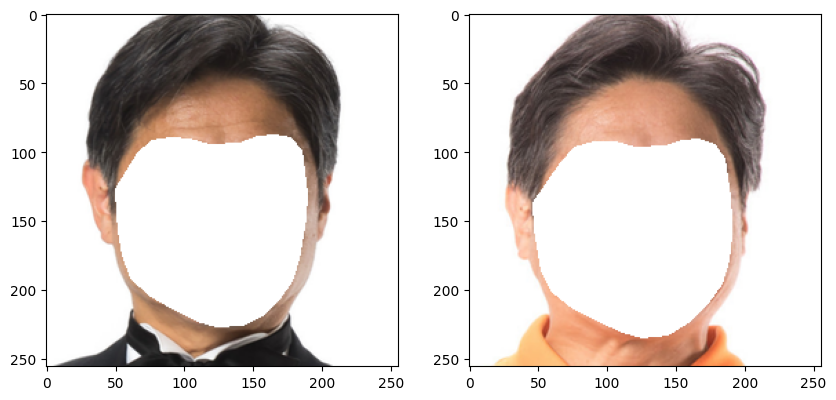

In [14]:
import matplotlib.pyplot as plt

# 領域を塗りつぶす色を指定
fill_color = (255, 255, 255)
# 塗りつぶし
cv2.fillPoly(img_from, [pt_from], fill_color)
cv2.fillPoly(img_to, [pt_to], fill_color)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_from)
ax[1].imshow(img_to)

plt.show()

マスクの作成

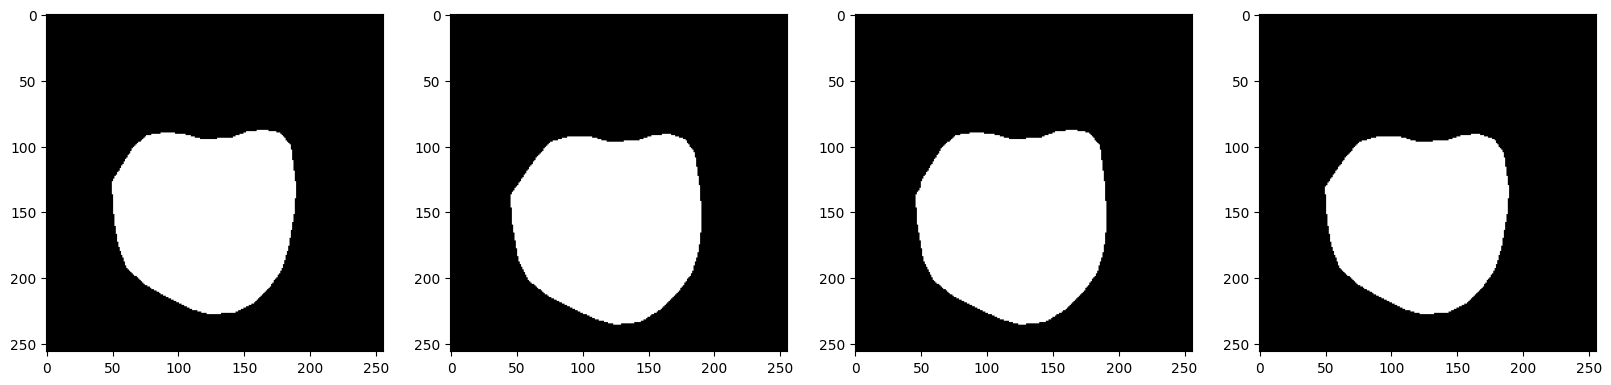

In [15]:
# 黒画像作成
mask = np.zeros(IMAGES[0].shape, IMAGES[0].dtype)
# fillPoly(黒画像, 点, 塗りつぶす色)
# 点を直線で結んだ多角形の領域を塗りつぶす
mask_from = cv2.fillPoly(mask.copy(), [pt_from], (255, 255, 255))
mask_to = cv2.fillPoly(mask.copy(), [pt_to], (255, 255, 255))
mask_or = mask_from | mask_to
mask_and = mask_from & mask_to

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(mask_from)
ax[1].imshow(mask_to)
ax[2].imshow(mask_or)
ax[3].imshow(mask_and)
plt.show()

切り抜き

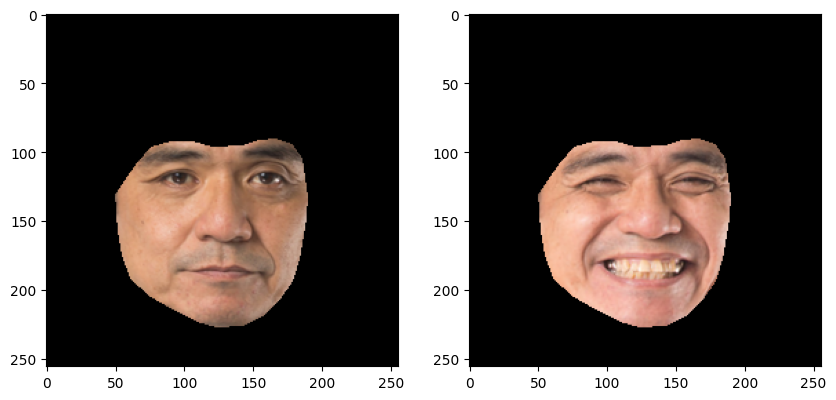

In [16]:
# 元の画像とマスクで切り抜き
crop_from = cv2.bitwise_and(IMAGES[0], mask_and)
crop_to = cv2.bitwise_and(IMAGES[1], mask_and)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(crop_from)
ax[1].imshow(crop_to)
plt.show()

のっぺらぼうの作成

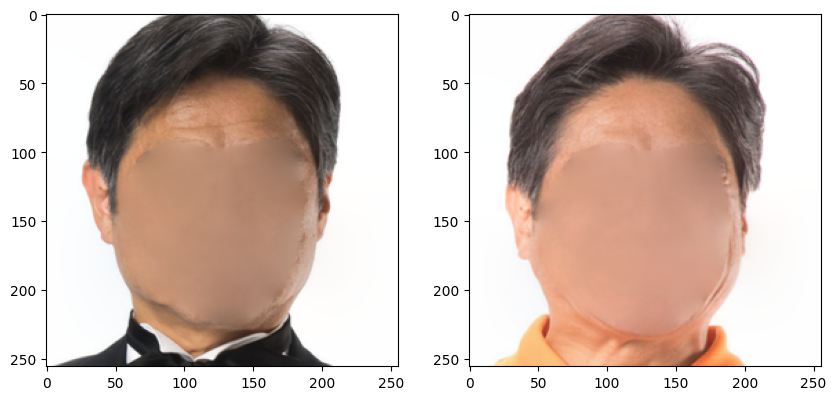

In [17]:
faceless_from = cv2.illuminationChange(IMAGES[0], mask_from, alpha=2, beta=2)
faceless_to = cv2.illuminationChange(IMAGES[1], mask_to, alpha=2, beta=2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(faceless_from)
ax[1].imshow(faceless_to)
plt.show()

合成

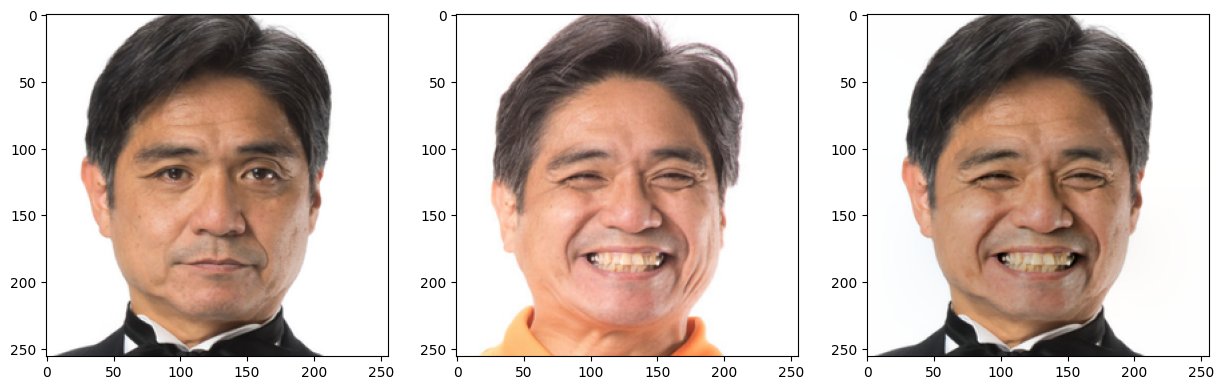

In [18]:
# 切り抜いた画像の中心を求めるための処理
monoMaskImage = cv2.split(mask_and)[0] # reducing the mask to a monochrome
br = cv2.boundingRect(monoMaskImage) # bounding rect (x,y,width,height)
center = (br[0] + br[2] // 2, br[1] + br[3] // 2)

# のっぺらぼうの画像にmask_andで切り抜いて
# fromに張り付けてなじませる
result = cv2.seamlessClone(IMAGES[1], faceless_from, mask_and, center, cv2.NORMAL_CLONE)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(IMAGES[0])
ax[1].imshow(IMAGES[1])
ax[2].imshow(result)

plt.show()

切り抜き画像の保存

In [20]:
dst_dir = f"test/crop/"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

cv2.imwrite(
    f"{dst_dir}/crop_from.png",
    cv2.cvtColor(crop_from, cv2.COLOR_RGB2BGR),
)
cv2.imwrite(
    f"{dst_dir}/crop_to.png",
    cv2.cvtColor(crop_to, cv2.COLOR_RGB2BGR),
)

True

合成画像の保存

In [44]:
dst_dir = f"test/synthesis/{IMAGES_NAME[0]}-{IMAGES_NAME[1]}"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

cv2.imwrite(
    f"{dst_dir}/face_smile.png",
    cv2.cvtColor(result, cv2.COLOR_RGB2BGR),
)

True